In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from datetime import datetime
from datetime import date
import os
import random

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier


from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

# Save model
import pickle
import joblib

In [2]:
# dynamic path location

# running = 'movies'
# fileName = 'data1_Data_Movies'
# fileName = 'data2_Movies_WithAwards'
# fileName = 'data3_USA_Movies_WithAwards'

running = 'directors'
fileName = '1_Director_Data_Mar-21-2020'
# fileName = '2_Director_Data_Enhanced_May-10-2020'
# fileName = '3_USA_Director_Specific_dataset_May-15-2020'


directorDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\'+ fileName +'.csv')


# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\.csv')
# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\.csv')
# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\.csv')



saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

data = pd.read_csv(directorDataFileLocation)


# Notebook Run Settings

chosen_feature_predicting : Gender, rating_count , rating_value , review_count_critic , review_count_user , metascore
<br>chosen_bin_method : quartiles , bin_cut , Bin_AsPaper
<br>chosen_success_class : movie_rating , director_rating
<br>chosen_dataset_balance : unbalanced , balanced
<br>chosen_kernel_type : linear , poly , rbf, LinearSVC
<br>chosen_scaling_method : MinMaxScaler , None

In [3]:
if (running == 'directors'):
    
    chosen_feature_predicting = 'Gender'
    chosen_dataset_ratio = 'balanced'
    chosen_kernel_type = 'LinearSVC'
    chosen_gamma_type = 'auto'
    chosen_scaling_method = 'MinMaxScaler'
    chosen_random_state = 42
    
    
    
elif(running == 'movies'):
    
    chosen_feature_predicting = 'Gender'
    chosen_dataset_ratio = 'balanced'
    chosen_kernel_type = 'LinearSVC'
    chosen_gamma_type = 'auto'
    chosen_scaling_method = 'MinMaxScaler'
    chosen_random_state = 42

In [4]:
# storeDF_col_names =  ['run_model','features_selected', 'record_count', 'male_count','female_count','predicting','Order_ABS','Order_Pos_Neg',
#               'TN','FP','FN','TP','total_time']
# # storeDF  = pd.DataFrame(columns = storeDF_col_names)

In [5]:
# Generic function to equally max split the dataframe with respect to the column Name, in our case the Gender column.

def max_equal_split_on_columnName(df,columnName='Gender'):
    df1 = pd.DataFrame()
    for i in df[columnName].value_counts().index:
        df1 = df1.append(df[(df[columnName]==i)]
                         .sample(n=df[columnName]
                                 .value_counts()
                                 .values.min(),
                                 replace = False,
                                random_state = chosen_random_state)
                        )        
    return df1.reset_index(drop=True)

### Balance data

In [6]:
balanced_data = max_equal_split_on_columnName(data)

In [7]:
# Unique director distribution in max_equal DF
print("Unique director distribution - balanced data split based on Gender")

balanced_data.drop_duplicates(subset = 'director_ids', keep = 'first').Gender.value_counts()

Unique director distribution - balanced data split based on Gender


Male      8991
Female    8991
Name: Gender, dtype: int64

In [8]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17982 entries, 0 to 17981
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   director_ids              17982 non-null  object 
 1   director_name             17982 non-null  object 
 2   movies_produced           17982 non-null  int64  
 3   average_rating_value      17982 non-null  float64
 4   average_rating_count      17982 non-null  float64
 5   career_Length             17982 non-null  int64  
 6   Gender                    17982 non-null  object 
 7   birthYear                 17982 non-null  int64  
 8   primaryProfession         17982 non-null  object 
 9   knownForTitles            17982 non-null  object 
 10  CareerStartYear           17982 non-null  int64  
 11  median_inter_event_time   17982 non-null  float64
 12  average_movie_per_year    17982 non-null  float64
 13  average_inter_event_time  17982 non-null  float64
dtypes: flo

In [9]:
balanced_data.shape

(17982, 14)

### Unbalanced data

In [10]:
# Unique director distribution in max_equal DF
print("Unique director distribution - Unbalanced data split based on Gender")

data.drop_duplicates(subset = 'director_ids', keep = 'first').Gender.value_counts()

Unique director distribution - Unbalanced data split based on Gender


Male      32638
Female     8991
Name: Gender, dtype: int64

In [11]:
data.shape

(41629, 14)

### Choosing dataset for the analysis

In [12]:
chosen_dataset_ratio

'balanced'

In [13]:
chosen_dataframe = ''
if(chosen_dataset_ratio == 'unbalanced'):
    chosen_dataframe = data
elif(chosen_dataset_ratio == 'balanced'):
    chosen_dataframe = balanced_data

### Remove Features from dataset which are not required

In [14]:
object_features_to_remove = chosen_dataframe.select_dtypes(include = 'object').columns.values.tolist()
object_features_to_remove.remove('Gender')
object_features_to_remove

['director_ids', 'director_name', 'primaryProfession', 'knownForTitles']

### Drop features from chosen Dataset

In [15]:
print('The shape of our chosen Movies dataset before removing object type features:', chosen_dataframe.shape)
# movies_data = movies_data[movies_data.columns.difference(object_features_to_remove)]
chosen_dataframe = chosen_dataframe.drop(columns= object_features_to_remove)
print('The shape of our chosen Movies dataset after dropping object type features:', chosen_dataframe.shape)

The shape of our chosen Movies dataset before removing object type features: (17982, 14)
The shape of our chosen Movies dataset after dropping object type features: (17982, 10)


In [16]:
chosen_dataframe[chosen_feature_predicting].value_counts()

Male      8991
Female    8991
Name: Gender, dtype: int64

In [17]:
numericalGender = {"Male": 1, "Female": 0 }
chosen_dataframe.Gender.replace(numericalGender,inplace=True)

# Observations

In [18]:
def one_hot_encode_gender(df,one_hot_feature = 'Gender'):
    print('Before one hot encoding , Shape ;', df.shape)
    # one hot encoding of Gender
    df = pd.concat([df, pd.get_dummies(df[one_hot_feature],prefix= one_hot_feature,dtype = int)],axis=1)
    df.drop([one_hot_feature],axis=1, inplace=True)
    print('After one hot encoding , Shape ;', df.shape)
    df.head(2)
    return df

In [19]:
# Function to Plot - Distribution of rating value among male and female. 

def plot_features_WRT_gender(df,columnCriteriaName,columnFeatureName):
    dict={}
    for i in df[columnCriteriaName].value_counts().index:
        dict["{0}_{1}".format(columnFeatureName,i)] = df[(df[columnCriteriaName] == i)][columnFeatureName]
    for k,v in dict.items():
        sns.distplot(v,label=[k])
        plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

### Generic Functions

In [20]:
# Helper method for save_to_file

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [21]:
# Function: Save Dataframe to CSV

def save_to_file(dataFrame, folderPath):
    today = date.today()
    todayDate = today.strftime("%b-%d-%Y")
#     dataFrame.to_csv(folderPath+ '\\' + get_df_name(dataFrame) + '_' + todayDate  + '.csv',index=False, encoding="utf8" )
    dataFrame.to_csv(folderPath+ '\\' + get_df_name(dataFrame) + '_' + todayDate  + '.csv',index=False, encoding="utf-8-sig" )

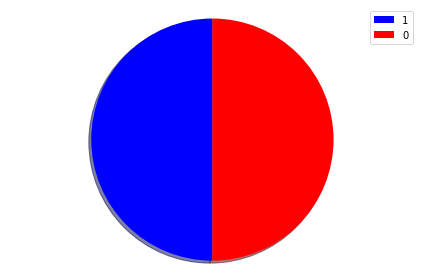

In [22]:
# Visualizing Outcome Distribution 
temp = chosen_dataframe[chosen_feature_predicting].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['blue', 'red', 'lightskyblue', 'lightcoral','cyan']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [23]:
def divide_test_train_with_scaling_methods(df,predict= chosen_feature_predicting,scalingMethod = "MinMaxScaler"):
    
    
    # Feature matrix and target variable
    X = df.drop(predict,axis = 'columns')
    y = df[predict]
    
    # Scaling
    if (scalingMethod == "MinMaxScaler"):
        print("The scaling method used is : ",scalingMethod)
        scaler = MinMaxScaler()
        new_X = scaler.fit_transform(X)
        # X_test = scaler.transform(X_test)
        
    else:
        print("No Scaling Method used or incorrect input")
        new_X = X
    
    # Divide the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.20, random_state = 42 , stratify = y )
    
    return X_train, X_test, y_train, y_test

# Plot Confusion Matrix

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Function for Run Info :

In [25]:
def run_info(classifier):
    print('\n**Run Info - ' + classifier + '**')
    print('Dataset Shape :', chosen_dataframe.shape)
    print('Dataset ratio of classes is', chosen_dataset_ratio)
    print('Predicting feature :', chosen_feature_predicting)
    print('Scaling Method :', chosen_scaling_method)
    print('****************\n')
    return

### Function to print customized classification report

In [26]:
def customized_classification_report(y_true,y_pred, AUCROC ):
    
    cols_to_use_classification_report = ['Female','Male','accuracy']
    
    reportGBClassification = classification_report(y_true,
                                               y_pred,
                                               output_dict=True)

    reportDF = pd.DataFrame(reportGBClassification)[0:3]
    reportDF = reportDF[['0','1','accuracy']]


    reportDF[['0','1']] = reportDF[['0','1']].round(2)
    accuracyRow = reportDF['accuracy'].unique().tolist()

    reportDF.drop(columns='accuracy',inplace= True)

    reportDF.loc[len(reportDF)] = 2 * accuracyRow
    reportDF.loc[len(reportDF)] = 2 * [AUCROC]

    reportDF = reportDF.rename(index = {3:'accuracy',4:'AUC ROC'})
    return reportDF

# SVM Classifier

In [27]:
def train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType='linear',gamma_parameter='auto'):
    
    start = time.time()
    print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))
    
    labelClass = [0,1]
#     labelMovieClass = [1,2,3,4]
    
    # SVM Classifier parameters
    
    if(kernelType == 'linear'):
        svclassifier = SVC(kernel = kernelType,
                           gamma = gamma_parameter,
                           probability=True
                          )
        
    elif(kernelType == 'LinearSVC'):
        svclassifier = LinearSVC(random_state = 42,
                                 tol=1e-5,
                                 multi_class = 'ovr'
                                )
        # Using Calibrated Classifier cross validation and One VsRest classifier
        clf0 = CalibratedClassifierCV(svclassifier, cv=10)
        clf = OneVsRestClassifier(clf0, n_jobs = 10)
        
    elif(kernelType == 'poly'):
        svclassifier = SVC(kernel=kernelType,
                           gamma = gamma_parameter,
#                            probability=True,
                           degree=8
                          )
    elif(kernelType == 'rbf'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                    )
    elif(kernelType == 'sigmoid'):
        svclassifier = SVC(kernel=kernelType,
#                            probability=True,
                )
    
#     #Using Bagging classifier with SVC
#     clf = BaggingClassifier(base_estimator = svclassifier,
#                                      n_estimators=10, 
#                                      random_state= 42)    
    
#     #Using One Vs Rest classifier with SVC    
#     clf = OneVsRestClassifier(svclassifier, n_jobs = 10)
    
     



    
    # SVM Classifier Fit
    clf.fit(X_train, y_train)

    # Predict classes
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    
#     cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelMovieClass )
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
    
    classifier_name = svclassifier.__class__.__name__
    train_size = int(round((len(X_train) / len(chosen_dataframe)),1) * 100)
    test_size = int(round((len(X_test) / len(chosen_dataframe)),1) * 100)
    
    # Print run info
    run_info(classifier_name)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelClass,
                      title='Confusion matrix, without normalization')
    
       
    svm_train_score = clf.score(X_train, y_train)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_train_score,3),train_size))
    
    svm_test_score = clf.score(X_test, y_test)
    print("Testing Score of {0} on {2} % data : {1} ".format(classifier_name,round(svm_test_score,3),test_size))

    # Performance metrics
    
    auc_roc = roc_auc_score(y_test, y_pred)
    print( "\nArea Under the Curve - ROC (OVO , Macro) : ",round(auc_roc,3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))
    

    print("\nClassification Report\n")
    print(classification_report(y_test, y_pred, labels = labelClass ))
    
    # Stop timer
    end = time.time()
    print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
    total_time = str(round((end - start)/60,2))
    print("Total time taken in seconds: " + str((end - start)))
    
    return svclassifier,y_test,y_pred,auc_roc

## Running Director Dataset - with model features

### Small sample for test

In [28]:
# for i in range(2):
#     print('Round',i+4)
#     NOR= 10000 * (i+4)
#     print('Number of Rows',NOR)
#     testSample =  chosen_dataframe.sample(n= NOR , random_state = 42 , replace = False)
#     # Divide the data into training and test
#     X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(testSample,scalingMethod= chosen_scaling_method)
#     svclassifier,total_time = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)
#     print('Total Time in minutes: ', total_time )

In [29]:
# # Comment this line if you want to use the originally chosen dataframe

# testSample =  chosen_dataframe.sample(n= 10000 , random_state = 42 , replace = False)
# # chosen_dataframe = testSample

In [30]:
chosen_dataframe[chosen_dataframe['birthYear'] == 6]

,movies_produced,average_rating_value,average_rating_count,career_Length,Gender,birthYear,CareerStartYear,median_inter_event_time,average_movie_per_year,average_inter_event_time


In [31]:
# Divide the data into training and test

X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(chosen_dataframe,scalingMethod= chosen_scaling_method)

The scaling method used is :  MinMaxScaler


In [32]:
X_train.shape , y_train.shape

((14385, 9), (14385,))

In [33]:
X_test.shape , y_test.shape

((3597, 9), (3597,))

For Dataset 1<br>
50 seconds for 10000 records<br>
200 seconds for 20000 records

Started Reading files at :2020-05-29 16:52:22

**Run Info - LinearSVC**
Dataset Shape : (17982, 10)
Dataset ratio of classes is balanced
Predicting feature : Gender
Scaling Method : MinMaxScaler
****************

Confusion matrix, without normalization
[[1216  583]
 [1032  766]]

Training Score of LinearSVC on 80 % data : 0.557 
Testing Score of LinearSVC on 20 % data : 0.551 

Area Under the Curve - ROC (OVO , Macro) :  0.551
Matthews_corrcoef :  0.105

Classification Report

              precision    recall  f1-score   support

           0       0.54      0.68      0.60      1799
           1       0.57      0.43      0.49      1798

    accuracy                           0.55      3597
   macro avg       0.55      0.55      0.54      3597
weighted avg       0.55      0.55      0.54      3597


Stopped Reading files at :2020-05-29 16:52:24
Total time taken in seconds: 2.577714681625366


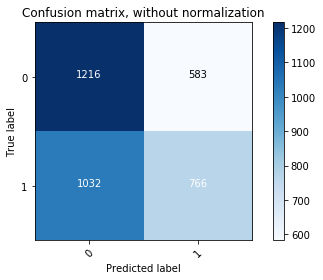

In [34]:
svclassifier,y_true , y_pred, AUCROC  = train_model_SVM_classifier(X_train, X_test, y_train, y_test,kernelType= chosen_kernel_type ,gamma_parameter= chosen_gamma_type)

In [35]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1216,  583],
       [1032,  766]], dtype=int64)

In [36]:
SVM_reportDF = customized_classification_report(y_true,y_pred,AUCROC)
SVM_reportDF[['1','0']]

,1,0
precision,0.570000,0.540000
recall,0.430000,0.680000
f1-score,0.490000,0.600000
accuracy,0.551015,0.551015
AUC ROC,0.550980,0.550980


In [37]:
break

SyntaxError: 'break' outside loop (<ipython-input-37-6aaf1f276005>, line 4)

# Code ends here for SVM Testing

In [ ]:
# temp_director_only = movies_data.dropna(subset=model_features)
temp_director_only = movies_data
temp_director_only.info()

In [ ]:
def print_features_selected(df):
    print('[',end = '')
    for i,v in enumerate(df.columns.values):
        if(i==len(df.columns.values)-1):
            print("'" + str(v) +"']")
        else:
            print("'" + str(v) +"',")

In [ ]:
# # print_features_selected(temp_director_only)
# print_features_selected(maxEqualDF[model_features])

## Running Whole Director DF 

In [ ]:
y_test,y_pred,model_SVC = run_model_SVM(df = temp_director_only,
                                        predictingFeature= chosen_feature_predicting,
                                        kernelType= chosen_kernel_type,
                                        gamma= chosen_gamma_type
                                       )


In [ ]:
# y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,temp_director_only,storeDF,
#                                                                   model_features,'Gender','linear','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

In [ ]:
# #Save a copy of true and predicted for Manual intervention
# Actual = y_test.to_frame()
# Actual['predicter'] = y_pred
# save_to_file(Actual,saveFileToPath)

## Running Balanced max Equal DF 

In [ ]:
y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,maxEqualDF,storeDF,
                                                                  model_features,'Gender','linear','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

## Test Run sample DF

In [ ]:
y_test,y_pred,model_SVC,storeDF.loc[len(storeDF)] = run_model_SVM(model_comments,equalDF,storeDF,
                                                                  model_features,'Gender','poly','auto')

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
evaluation_analysis(y_test,y_pred)

In [ ]:
storeDF

In [ ]:
save_to_file(storeDF,saveFileToPath)